<a href="https://colab.research.google.com/github/GirolamoOddo/AppliedMath_Notebooks/blob/main/FNN_for_InverseStructuralProblem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0) INTRODUCTION

This code aims to solve a Design problem using neural networks. In particular, based on a finite element solver, several simulations of a fixed-end beam with load at the free end are solved, and the question arises: Can a neural network solve the inverse problem where the material and the point with maximum deformation are provided as input, and the acting load is requested as output? This can be seen as a design tool where it is not necessary to perform an iterative process to reconstruct the acting load, but there is the possibility of already having a solution close to the correct result.  

The notebook is therefore divided into 3 main sections:   
- one where the finite element solver for the fixed-end beam problem with load at the free end is written.  
- training of a network for the direct problem, purely for didactic purposes.   
-the last step where instead the network is trained for the inverse problem described above.
>  
>  

The reference implementation for the FEM solver is as follows:  
https://polymerfem.com/full-finite-element-solver-in-100-lines-of-python/
___
CORE DEPENDENCIES

>numpy: 1.25.2  
tensorflow: 2.15.0  
keras: 2.15.0  
matplotlib: 3.7.1  
numba: 0.58.1  

In [1]:
# @title IMPORTS

import numpy as np
import math
import matplotlib.pyplot as plt
from numba import jit
import warnings


import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import GlorotUniform
from multiprocessing import Pool, cpu_count

from IPython.display import Image
from tensorflow.keras.utils  import plot_model

import time
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

#_______________________________________________________________________________
# CHECK PACKAGES VERSION:
#_______________________________________________________________________________
#import os
#packages = [
#    'numpy',
#    'tensorflow',
#    'keras',
#    'matplotlib',
#    'numba',
#    'math',
#    'multiprocessing',
#    'sklearn',
#    'time'
#]
#
#for package in packages:
#    try:
#        version = os.popen(f"pip show {package} | grep Version").read().strip().split(': ')[1]
#        print(f"{package}: {version}")
#    except Exception as e:
#        print(f"Error getting version for {package}: {e}")
#
#_______________________________________________________________________________
# THE FOLLOWING CODE WORKS PROPERLY WITH THESE PACKAGES VERSION:
#_______________________________________________________________________________
#numpy: 1.25.2
#tensorflow: 2.15.0
#keras: 2.15.0
#matplotlib: 3.7.1
#numba: 0.58.1
#_______________________________________________________________________________

# 1) FEM SOLVER  
In this section, a finite element solver is implemented in order to generate data and serve as a reference for future analyses.



In [2]:
# @title FEM CORE SECTION

class ScalarParameters:
    def __init__(self, E, v, load, material_model):
        self.E = E
        self.v = v
        self.load = load
        self.material_model = material_model

class ShapeFunction:
    @staticmethod
    def shape(xi):
        x,y = tuple(xi)
        N = [(1.0-x)*(1.0-y), (1.0+x)*(1.0-y), (1.0+x)*(1.0+y), (1.0-x)*(1.0+y)]
        return 0.25*np.array(N)

    @staticmethod
    def gradshape(xi):
        x,y = tuple(xi)
        dN = [[-(1.0-y),  (1.0-y), (1.0+y), -(1.0+y)],
              [-(1.0-x), -(1.0+x), (1.0+x),  (1.0-x)]]
        return 0.25*np.array(dN)

class FiniteElementModel:
    def __init__(self, mesh_ex, mesh_ey, mesh_lx, mesh_ly, scalar_params):
        self.mesh_ex = mesh_ex
        self.mesh_ey = mesh_ey
        self.mesh_lx = mesh_lx
        self.mesh_ly = mesh_ly
        self.scalar_params = scalar_params

    def create_mesh(self):
        mesh_nx = self.mesh_ex + 1
        mesh_ny = self.mesh_ey + 1
        num_nodes = mesh_nx * mesh_ny

        nodes = []
        for y in np.linspace(0.0, self.mesh_ly, mesh_ny):
            for x in np.linspace(0.0, self.mesh_lx, mesh_nx):
                nodes.append([x,y])
        nodes = np.array(nodes)

        conn = []
        for j in range(self.mesh_ey):
            for i in range(self.mesh_ex):
                n0 = i + j * mesh_nx
                conn.append([n0, n0 + 1, n0 + 1 + mesh_nx, n0 + mesh_nx])

        return nodes, conn

    def material_model(self):
        if self.scalar_params.material_model == 'plane_strain':
            return self.material_model_plane_strain()
        elif self.scalar_params.material_model == 'plane_stress':
            return self.material_model_plane_stress()
        elif self.scalar_params.material_model == 'linear_elastic_isotropic':
            return self.material_model_linear_elastic_isotropic()
        else:
            raise ValueError("Invalid material model specified.")

    def material_model_plane_strain(self):
        E = self.scalar_params.E
        v = self.scalar_params.v
        C = E / (1.0 + v) / (1.0 - 2.0 * v) * np.array([[1.0-v, v, 0.0],
                                                         [v, 1.0-v, 0.0],
                                                         [0.0, 0.0, 0.5-v]])
        return C

    def material_model_plane_stress(self):
        E = self.scalar_params.E
        v = self.scalar_params.v
        C = E / (1 - v**2) * np.array([[1.0, v, 0.0],
                                       [v, 1.0, 0.0],
                                       [0.0, 0.0, (1 - v) / 2.0]])
        return C

    def material_model_linear_elastic_isotropic(self):
        E = self.scalar_params.E
        v = self.scalar_params.v
        G = E / (2 * (1 + v))  # Shear modulus
        lambda_ = (v * E) / ((1 + v) * (1 - 2 * v))  # Lame's first parameter
        mu = E / (2 * (1 + v))  # Lame's second parameter (Shear modulus)

        C = np.array([[lambda_ + 2 * mu, lambda_, 0.0],
                      [lambda_, lambda_ + 2 * mu, 0.0],
                      [0.0, 0.0, mu]])
        return C

    @jit(fastmath=True, looplift=True)
    def create_global_stiffness_matrix(self, nodes, conn, C):
        num_nodes = len(nodes)
        K = np.zeros((2*num_nodes, 2*num_nodes))
        q4 = [[x / math.sqrt(3.0), y / math.sqrt(3.0)] for y in [-1.0,1.0] for x in [-1.0,1.0]]
        B = np.zeros((3,8))
        for c in conn:
            xIe = nodes[c,:]
            Ke = np.zeros((8,8))
            for q in q4:
                dN = ShapeFunction.gradshape(q)
                J  = np.dot(dN, xIe).T
                dN = np.dot(np.linalg.inv(J), dN)
                B[0,0::2] = dN[0,:]
                B[1,1::2] = dN[1,:]
                B[2,0::2] = dN[1,:]
                B[2,1::2] = dN[0,:]
                Ke += np.dot(np.dot(B.T,C),B) * np.linalg.det(J)
            for i,I in enumerate(c):
                for j,J in enumerate(c):
                    K[2*I,2*J]     += Ke[2*i,2*j]
                    K[2*I+1,2*J]   += Ke[2*i+1,2*j]
                    K[2*I+1,2*J+1] += Ke[2*i+1,2*j+1]
                    K[2*I,2*J+1]   += Ke[2*i,2*j+1]
        return K

    @jit(fastmath=True, looplift=True)
    def solve_linear_system(self, K, nodes):
        num_nodes = len(nodes)
        f = np.zeros((2*num_nodes))
        for i in range(num_nodes):
            if nodes[i,1] == 0.0:
                K[2*i,:]     = 0.0
                K[2*i+1,:]   = 0.0
                K[2*i,2*i]   = 1.0
                K[2*i+1,2*i+1] = 1.0
            if nodes[i,1] == self.mesh_ly:
                x = nodes[i,0]
                f[2*i+1] = self.scalar_params.load[1]  # Load in y direction
                if x == 0.0 or x == self.mesh_lx:
                    f[2*i+1] *= 0.5
                f[2*i] = self.scalar_params.load[0]  # Load in x direction
                if x == 0.0 or x == self.mesh_lx:
                    f[2*i] *= 0.5
        u = np.linalg.solve(K, f)
        return u

    def plot_results(self, u):
        mesh_nx = self.mesh_ex + 1
        mesh_ny = self.mesh_ey + 1
        mesh_hx = self.mesh_lx / self.mesh_ex
        mesh_hy = self.mesh_ly / self.mesh_ey
        ux = np.reshape(u[0::2], (mesh_ny,mesh_nx))
        uy = np.reshape(u[1::2], (mesh_ny,mesh_nx))
        xvec = []
        yvec = []
        res  = []
        for i in range(mesh_nx):
            for j in range(mesh_ny):
                xvec.append(i*mesh_hx + ux[j,i])
                yvec.append(j*mesh_hy + uy[j,i])
                res.append(np.sqrt(ux[j,i]**2 + uy[j,i]**2))

        # Plot deformed shape
        plt.rcParams.update({'font.size': 24})
        plt.figure(figsize=(18, 9))
        plt.subplot(1, 2, 1)
        t = plt.tricontourf(xvec, yvec, res, levels=54, cmap=plt.cm.jet)
        plt.scatter(xvec, yvec, marker='o', c='b', s=2)
        plt.grid()
        cbar = plt.colorbar(t)  # Positioning the colorbar at the bottom center
        cbar.set_label('Displacement')  # Set label for colorbar
        plt.xlim(-10, 20)
        plt.ylim(-10, 60)
        plt.title('Deformed Shape')

        res  = np.zeros(len(res))
        # Plot undeformed shape
        plt.subplot(1, 2, 2)
        undeformed_x = np.linspace(0.0, self.mesh_lx, mesh_nx)
        undeformed_y = np.linspace(0.0, self.mesh_ly, mesh_ny)
        undeformed_X, undeformed_Y = np.meshgrid(undeformed_x, undeformed_y)
        t = plt.tricontourf(undeformed_X.flatten(), undeformed_Y.flatten(), np.zeros_like(undeformed_X.flatten()), levels=54, cmap=plt.cm.jet)
        plt.plot(undeformed_X, undeformed_Y, 'bo', markersize=2)
        plt.grid()
        cbar = plt.colorbar(t)  # Positioning the colorbar at the bottom center
        cbar.set_label('Displacement')  # Set label for colorbar
        plt.xlim(-10, 20)
        plt.ylim(-10, 60)
        plt.title('Undeformed Shape')

        plt.suptitle('Magnitude Displacement Plot')
        plt.tight_layout()
        plt.show()

        #-----------------------------------------------------------------------
        mesh_nx = self.mesh_ex + 1
        mesh_ny = self.mesh_ey + 1
        mesh_hx = self.mesh_lx / self.mesh_ex
        mesh_hy = self.mesh_ly / self.mesh_ey
        ux = np.reshape(u[0::2], (mesh_ny,mesh_nx))
        uy = np.reshape(u[1::2], (mesh_ny,mesh_nx))
        xvec = []
        yvec = []
        res  = []
        for i in range(mesh_nx):
            for j in range(mesh_ny):
                xvec.append(i*mesh_hx + ux[j,i])
                yvec.append(j*mesh_hy + uy[j,i])
                res.append(ux[j,i])

        # Plot deformed shape
        plt.rcParams.update({'font.size': 24})
        plt.figure(figsize=(18, 9))
        plt.subplot(1, 2, 1)
        t = plt.tricontourf(xvec, yvec, res, levels=54, cmap=plt.cm.jet)
        plt.scatter(xvec, yvec, marker='o', c='b', s=2)
        plt.grid()
        cbar = plt.colorbar(t)  # Positioning the colorbar at the bottom center
        cbar.set_label('Displacement')  # Set label for colorbar
        plt.xlim(-10, 20)
        plt.ylim(-10, 60)
        plt.title('u_x Deformed Shape')

        mesh_nx = self.mesh_ex + 1
        mesh_ny = self.mesh_ey + 1
        mesh_hx = self.mesh_lx / self.mesh_ex
        mesh_hy = self.mesh_ly / self.mesh_ey
        ux = np.reshape(u[0::2], (mesh_ny,mesh_nx))
        uy = np.reshape(u[1::2], (mesh_ny,mesh_nx))
        xvec = []
        yvec = []
        res  = []
        for i in range(mesh_nx):
            for j in range(mesh_ny):
                xvec.append(i*mesh_hx + ux[j,i])
                yvec.append(j*mesh_hy + uy[j,i])
                res.append(uy[j,i])

        # Plot deformed shape
        plt.subplot(1, 2, 2)
        t = plt.tricontourf(xvec, yvec, res, levels=54, cmap=plt.cm.jet)
        plt.scatter(xvec, yvec, marker='o', c='b', s=2)
        plt.grid()
        cbar = plt.colorbar(t)  # Positioning the colorbar at the bottom center
        cbar.set_label('Displacement')  # Set label for colorbar
        plt.xlim(-10, 20)
        plt.ylim(-10, 60)
        plt.title('u_y Deformed Shape')

        plt.suptitle('u_x-u_y Displacement Plot')
        plt.tight_layout()
        plt.show()

       #------------------------------------------------------------------------


create mesh
Material model - linear_elastic_isotropic
Create Materia Matrix: C
Create Global Stiffness Matrix: K
Solving Linear System
Max u= 2.2098
Plotting displacement


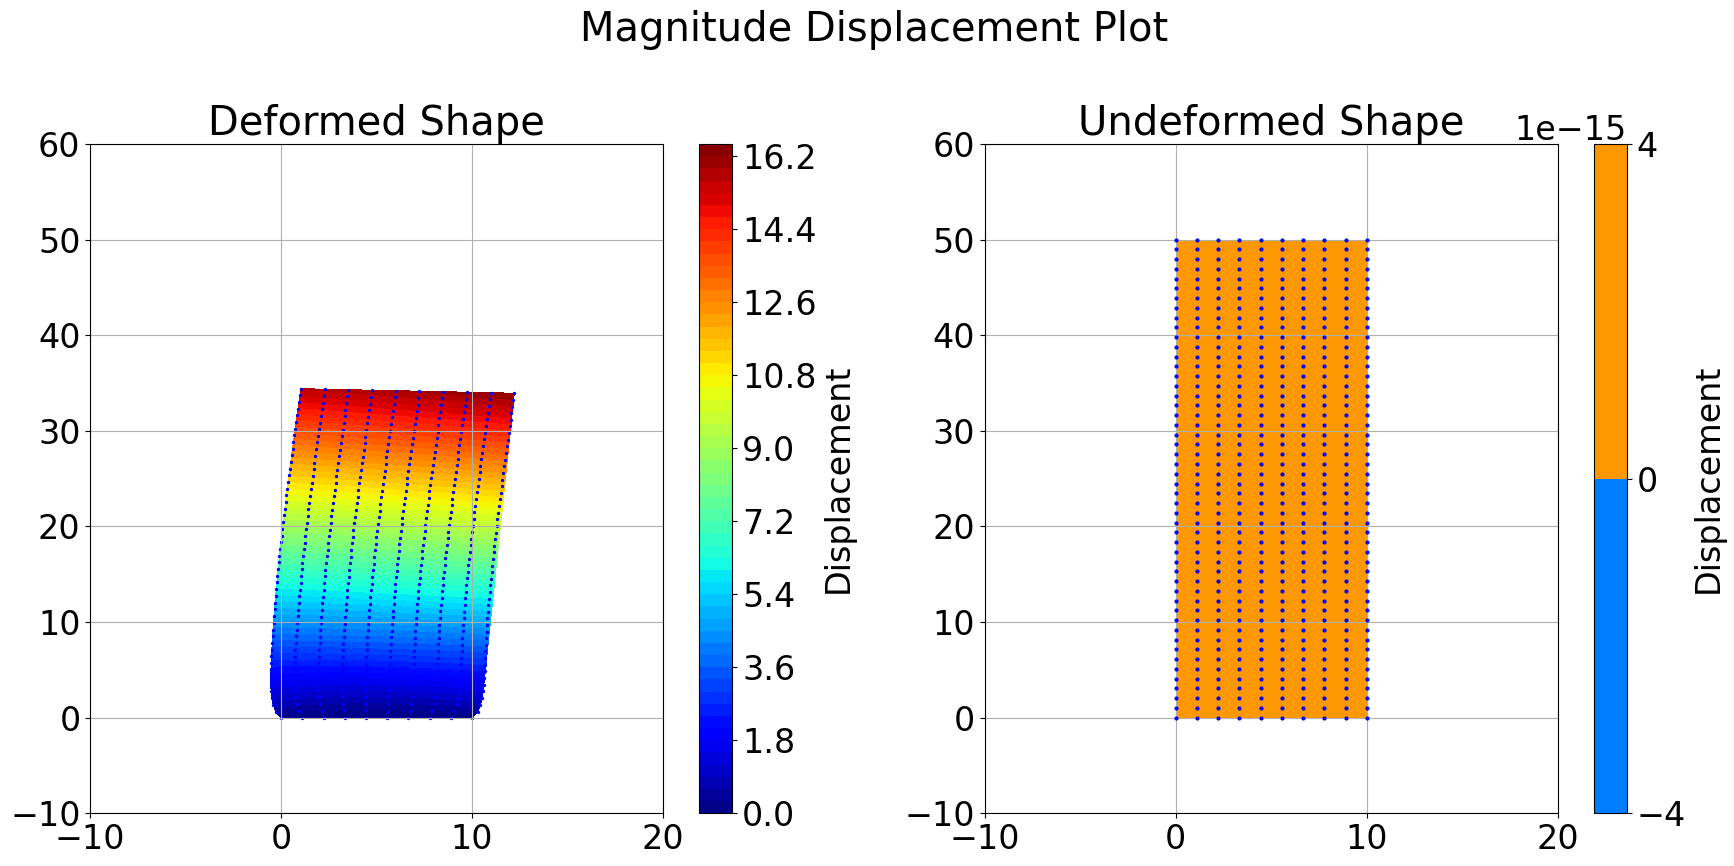

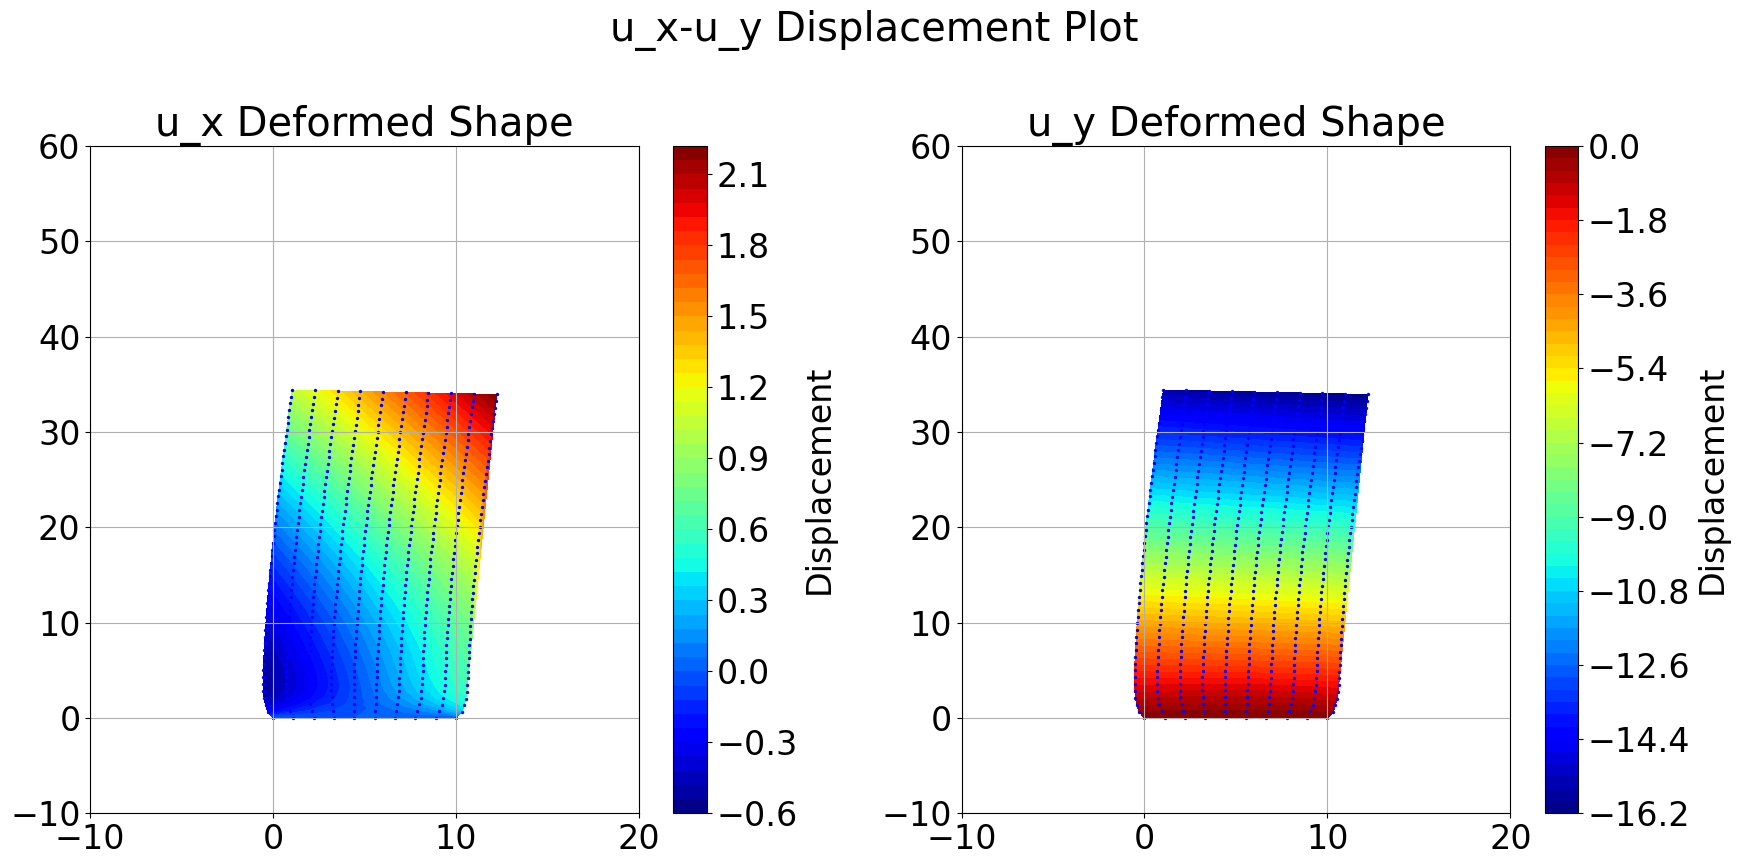

In [3]:
# @title MAIN SIMULATION SECTION

def main():
    print('create mesh')
    mesh_ex = 9
    mesh_ey = 49
    mesh_lx = 10.0
    mesh_ly = 50.0

    scalar_params = ScalarParameters(E=210.0, v=0.27, load=[+0.08, -80.0], material_model='linear_elastic_isotropic') #linear_elastic_isotropic

    fem = FiniteElementModel(mesh_ex, mesh_ey, mesh_lx, mesh_ly, scalar_params)
    nodes, conn = fem.create_mesh()

    print('Material model -', scalar_params.material_model)
    print('Create Materia Matrix: C')
    C = fem.material_model()

    print('Create Global Stiffness Matrix: K')
    K = fem.create_global_stiffness_matrix(nodes, conn, C)

    print('Solving Linear System')
    u = fem.solve_linear_system(K, nodes)
    print('Max u=', round(max(u), 4))

    print('Plotting displacement')
    fem.plot_results(u)

if True:
    main()

In [4]:
# @title SYNTETIC DATA GENERATION

num_processes = cpu_count()
print('Ready to run ', num_processes, ' simulation in parallel for data generation')
print()

seed = 89
np.random.seed(seed=seed)
tf.random.set_seed(seed=seed)
init=tf.keras.initializers.GlorotNormal(seed=seed)
keras.utils.set_random_seed(seed=seed)

num_samples = 15000
mesh_ex = 9
mesh_ey = 49
mesh_lx = 10.0
mesh_ly = 50.0
material_model = 'linear_elastic_isotropic'
load_range = [-10.0, 10.0]

def generate_sample(args):
    mesh_ex, mesh_ey, mesh_lx, mesh_ly, material_model, load_range = args

    load_x = np.random.uniform(load_range[0], load_range[1])
    while np.abs(load_x) < 0.005:
          load_x = np.random.uniform(load_range[0], load_range[1])
    load_y = np.random.uniform(load_range[0], load_range[1])
    load = [load_x, load_y]
    E = np.random.uniform(500.0, 2000.0)
    v = np.random.uniform(0.2, 0.4)

    scalar_params = ScalarParameters(E, v, load, material_model)
    fem = FiniteElementModel(mesh_ex, mesh_ey, mesh_lx, mesh_ly, scalar_params)
    nodes, conn = fem.create_mesh()
    C = fem.material_model()
    K = fem.create_global_stiffness_matrix(nodes, conn, C)
    u = fem.solve_linear_system(K, nodes)
    max_u = max(u)

    mesh_nx = mesh_ex + 1
    mesh_ny = mesh_ey + 1
    mesh_hx = mesh_lx / mesh_ex
    mesh_hy = mesh_ly / mesh_ey
    ux = np.reshape(u[0::2], (mesh_ny,mesh_nx))
    uy = np.reshape(u[1::2], (mesh_ny,mesh_nx))
    xvec = []
    yvec = []
    res  = []
    for i in range(mesh_nx):
        for j in range(mesh_ny):
            xvec.append(i*mesh_hx + ux[j,i])
            yvec.append(j*mesh_hy + uy[j,i])
            res.append(np.sqrt(ux[j,i]**2 + uy[j,i]**2))

    idx_max_u = np.argmax(res)
    max_u_coords = (xvec[idx_max_u], yvec[idx_max_u])

    print(f"E, v, load_x, load_y, max(u), max_u_coords_x, max_u_coords_y: {E}, {v}, {load[0]}, {load[1]}, {max_u}, {max_u_coords[0]},  {max_u_coords[1]}")
    print()

    return scalar_params.E, scalar_params.v, scalar_params.load[0], scalar_params.load[1], max_u, max_u_coords[0], max_u_coords[1]

def generate_training_data(num_samples, mesh_ex, mesh_ey, mesh_lx, mesh_ly, material_model, load_range):
    args = [(mesh_ex, mesh_ey, mesh_lx, mesh_ly, material_model, load_range)] * num_samples
    with Pool(processes=num_processes) as pool:
        training_data = pool.map(generate_sample, args)
    return training_data


training_data_unnorm = generate_training_data(num_samples, mesh_ex, mesh_ey, mesh_lx, mesh_ly, material_model, load_range)
norm_vect = np.array([2000.0, 0.5, load_range[1], load_range[1], 100, 100, 100])
training_data = np.array(training_data_unnorm) / norm_vect

np.save('training_data.npy', training_data_unnorm)
training_data_unnorm = np.load('training_data.npy')


Output streaming troncato alle ultime 5000 righe.
E, v, load_x, load_y, max(u), max_u_coords_x, max_u_coords_y: 1193.6158356653305, 0.24110888836954525, -1.1887115739878578, -9.087730359617014, 0.3491554581738639, -4.3213467517827615,  49.04738292865818

E, v, load_x, load_y, max(u), max_u_coords_x, max_u_coords_y: 621.9840594776975, 0.22423355799333805, 1.8571629037346327, -0.7559387655883825, 13.038340587440269, 23.038340587440267,  48.039704542440745

E, v, load_x, load_y, max(u), max_u_coords_x, max_u_coords_y: 879.0519289624574, 0.24448148927282937, -9.713903320738703, -8.966318905785165, 6.558909349038987, -47.76347423132478,  42.582688513761305

E, v, load_x, load_y, max(u), max_u_coords_x, max_u_coords_y: 965.0129698939377, 0.2684157821719698, -7.2012802494460715, 4.3043141097624655, 4.836908234440076, -21.810495615102585,  54.836908234440074

E, v, load_x, load_y, max(u), max_u_coords_x, max_u_coords_y: 1298.5805437857405, 0.38058726113693225, -9.528358185341109, -5.1923454779

# 2) DIRECT PROBLEM - NN  
In this section, solely for didactic demonstrative purposes, we inquire whether a Fully Connected network can approximate the results of the FEM solver and quantify the resulting error.

Epoch 1/35
47/47 [==============================] - 19s 7ms/step - loss: 0.0293 - val_loss: 0.0074
Epoch 2/35
47/47 [==============================] - 0s 5ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 3/35
47/47 [==============================] - 0s 5ms/step - loss: 0.0061 - val_loss: 0.0059
Epoch 4/35
47/47 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 5/35
47/47 [==============================] - 0s 4ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 6/35
47/47 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 7/35
47/47 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 8/35
47/47 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 9/35
47/47 [==============================] - 0s 9ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 10/35
47/47 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 11/35
47/47 

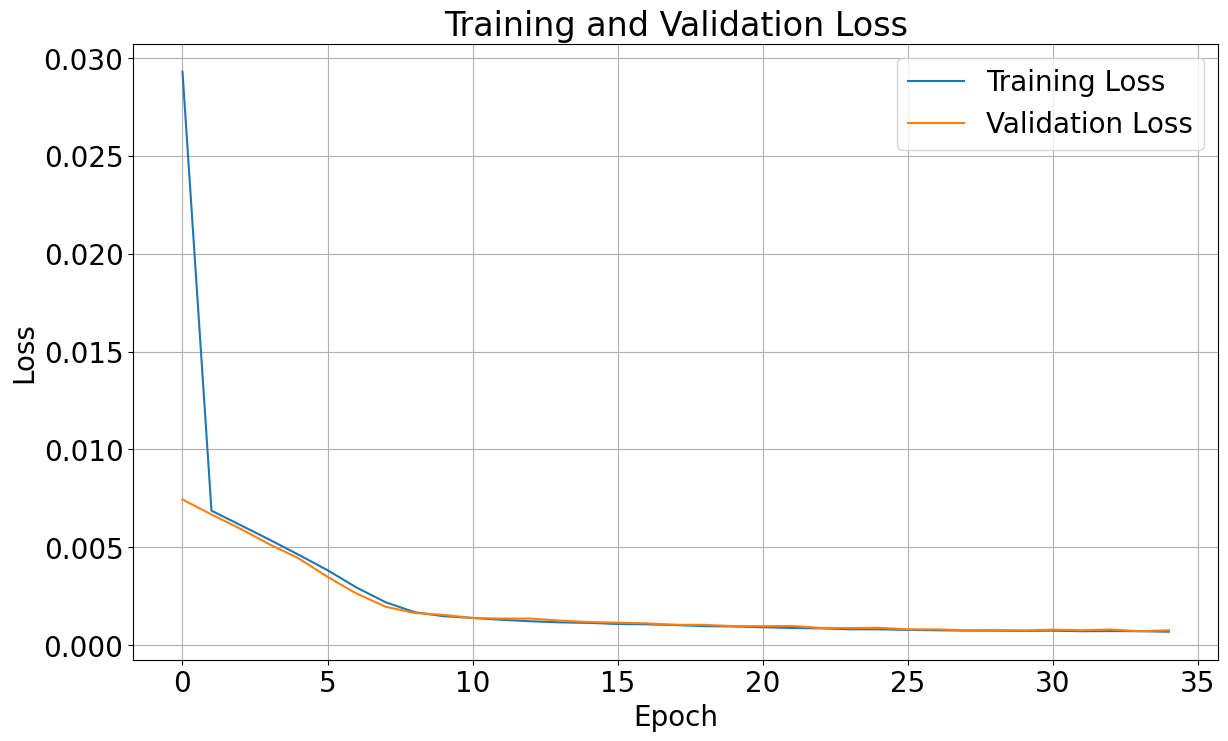

469/469 [==============================] - 1s 2ms/step - loss: 7.1931e-04
Loss on Validation: 0.0007193127530626953


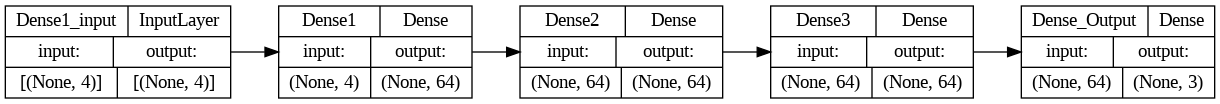

In [17]:
# @title TRAIN NEURAL-NETWORK - DIRECT PROBLEM

def plot_loss(history):
    plt.figure(figsize=(14, 8))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

X = training_data[:,  0 : -3]
y = training_data[:, -3 :   ]

model_direct = Sequential([
    Dense(64, input_shape=(4,), activation='elu', kernel_initializer=GlorotUniform(seed=seed), use_bias=False, name='Dense1'),
    Dense(64, activation='tanh', kernel_initializer=GlorotUniform(seed=seed), use_bias=False, name='Dense2'),
    Dense(64, activation='tanh', kernel_initializer=GlorotUniform(seed=seed), use_bias=True, name='Dense3'),
    Dense(3,  name='Dense_Output')
])

model_direct.compile(optimizer='adam', loss='mean_squared_error')


history = model_direct.fit(X, y, epochs=35, batch_size=256, validation_split=0.2)
plot_loss(history)

loss = model_direct.evaluate(X, y)
print("Loss on Validation:", loss)

model_direct.save("FEM_model.h5")
plot_model(model_direct, to_file='FEM_model_plot.png', show_shapes=True, show_layer_names=True, rankdir='LR')
Image('FEM_model_plot.png')


In [40]:
# @title TEST NEURAL NETWORK - DIRECT PROBLEM

# Compare Resuls

example_input = np.array([[850.0, 0.38, -2.0, -5.0]])

norm_vect = np.array([2000.0, 0.5, load_range[1], load_range[1]])
example_input_norm = np.array(example_input) / np.array(norm_vect)
start_time_inference = time.time()
predicted_max_u = model_direct.predict(example_input_norm) * 100
end_time_inference = time.time()
time_inference = end_time_inference - start_time_inference
print()
print('Example Test  [E, v, load_x, load_y] =', example_input[0])
print('____________________________________________________________________________')
print("NN max(u):              ", round(predicted_max_u[0][0], 4))
print("NN max(u)_coord:        ", round(predicted_max_u[0][1], 4), round(predicted_max_u[0][2], 4))
print("NN inference time [s]:  ", round(time_inference, 4))
print()

start_time_fem = time.time()
scalar_params_example = ScalarParameters(example_input[0][0], example_input[0][1], [example_input[0][2], example_input[0][3]], material_model)
fem_example = FiniteElementModel(mesh_ex, mesh_ey, mesh_lx, mesh_ly, scalar_params_example)
nodes_example, conn_example = fem_example.create_mesh()
C_example = fem_example.material_model()
K_example = fem_example.create_global_stiffness_matrix(nodes_example, conn_example, C_example)
u_example = fem_example.solve_linear_system(K_example, nodes_example)
max_u_example = max(u_example)

mesh_nx = mesh_ex + 1
mesh_ny = mesh_ey + 1
mesh_hx = mesh_lx / mesh_ex
mesh_hy = mesh_ly / mesh_ey
ux = np.reshape(u_example[0::2], (mesh_ny,mesh_nx))
uy = np.reshape(u_example[1::2], (mesh_ny,mesh_nx))
xvec = []
yvec = []
res  = []
for i in range(mesh_nx):
    for j in range(mesh_ny):
          xvec.append(i*mesh_hx + ux[j,i])
          yvec.append(j*mesh_hy + uy[j,i])
          res.append(np.sqrt(ux[j,i]**2 + uy[j,i]**2))

idx_max_u = np.argmax(res)
max_u_coords = (xvec[idx_max_u], yvec[idx_max_u])

end_time_fem = time.time()
time_fem = end_time_fem - start_time_fem
print("FEM max(u):             ", round(max_u_example, 4))
print("FEM max(u)_coord:       ", round(max_u_coords[0], 4), round(max_u_coords[1], 4))
print("FEM simulation time [s]:", round(time_fem, 4))

print()
error_perc = abs(predicted_max_u[0][0] - max_u_example) / max_u_example * 100
print("Error [%]:              ", round(error_perc, 4))
time_delta = abs(time_fem - time_inference) / time_fem * 100
print("Time Delta [%]:         ", round(time_delta, 4))


1/1 [==============================] - 0s 72ms/step

Example Test  [E, v, load_x, load_y] = [ 8.5e+02  3.8e-01 -2.0e+00 -5.0e+00]
____________________________________________________________________________
NN max(u):               1.3029
NN max(u)_coord:         -5.553 49.3359
NN inference time [s]:   0.2357

FEM max(u):              1.1195
FEM max(u)_coord:        -9.1723 48.4393
FEM simulation time [s]: 0.4154

Error [%]:               16.3811
Time Delta [%]:          43.2427


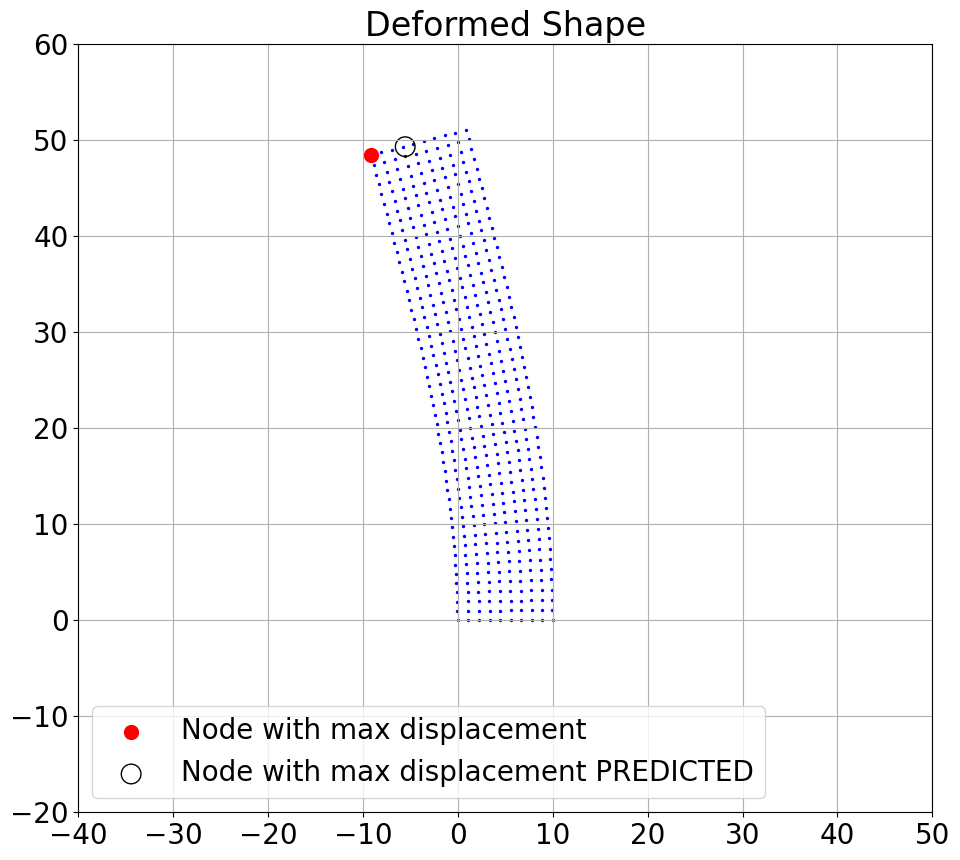

In [41]:
# @title PLOT RESULTS - DIRECT PROBLEM

def plot_results_NN(mesh_ex, mesh_ey, mesh_lx,  mesh_ly, u, predicted_max_u):

    mesh_nx = mesh_ex + 1
    mesh_ny = mesh_ey + 1
    mesh_hx = mesh_lx / mesh_ex
    mesh_hy = mesh_ly / mesh_ey
    ux = np.reshape(u[0::2], (mesh_ny,mesh_nx))
    uy = np.reshape(u[1::2], (mesh_ny,mesh_nx))
    xvec = []
    yvec = []
    res  = []
    for i in range(mesh_nx):
        for j in range(mesh_ny):
            xvec.append(i*mesh_hx + ux[j,i])
            yvec.append(j*mesh_hy + uy[j,i])
            res.append(np.sqrt(ux[j,i]**2 + uy[j,i]**2))

    idx_max_u = np.argmax(res)
    max_u_coords = (xvec[idx_max_u], yvec[idx_max_u])

    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(10, 9))

    plt.scatter(xvec, yvec, marker='o', c='b', s=2)
    plt.scatter(xvec[idx_max_u], yvec[idx_max_u], color='r', s=100, label='Node with max displacement')
    plt.scatter(predicted_max_u[0][1], predicted_max_u[0][2], edgecolors='k', facecolors='none', marker='o', s=200, label='Node with max displacement PREDICTED')
    plt.grid()
    plt.title('Deformed Shape')
    plt.xlim(-40, 50)
    plt.ylim(-20, 60)
    plt.legend(loc='lower left')

    plt.tight_layout()
    plt.show()

plot_results_NN(mesh_ex, mesh_ey, mesh_lx,  mesh_ly, u_example, predicted_max_u)

# 3) INVERSE PROBLEM - NN  


In this section, the real problem addressed in this notebook is approached, which is to provide the material data and the point where the maximum deformation occurs along with its magnitude in order to reconstruct the acting load. This serves as a design tool to avoid the iterative method. Obviously, given the time constraints involved, this tool is more of a stylistic exercise than a real tool, but it can still be interesting to see if useful results can be obtained through a neural rather than a classical approach.

Epoch 1/55
56/56 [==============================] - 1s 9ms/step - loss: 0.1973 - val_loss: 0.1755
Epoch 2/55
56/56 [==============================] - 0s 6ms/step - loss: 0.1651 - val_loss: 0.1495
Epoch 3/55
56/56 [==============================] - 0s 6ms/step - loss: 0.1447 - val_loss: 0.1282
Epoch 4/55
56/56 [==============================] - 0s 6ms/step - loss: 0.1239 - val_loss: 0.1177
Epoch 5/55
56/56 [==============================] - 0s 6ms/step - loss: 0.1094 - val_loss: 0.0988
Epoch 6/55
56/56 [==============================] - 0s 6ms/step - loss: 0.0982 - val_loss: 0.0892
Epoch 7/55
56/56 [==============================] - 0s 4ms/step - loss: 0.0877 - val_loss: 0.0807
Epoch 8/55
56/56 [==============================] - 0s 3ms/step - loss: 0.0803 - val_loss: 0.0757
Epoch 9/55
56/56 [==============================] - 0s 4ms/step - loss: 0.0772 - val_loss: 0.0724
Epoch 10/55
56/56 [==============================] - 0s 4ms/step - loss: 0.0727 - val_loss: 0.0684
Epoch 11/55
56/56 [

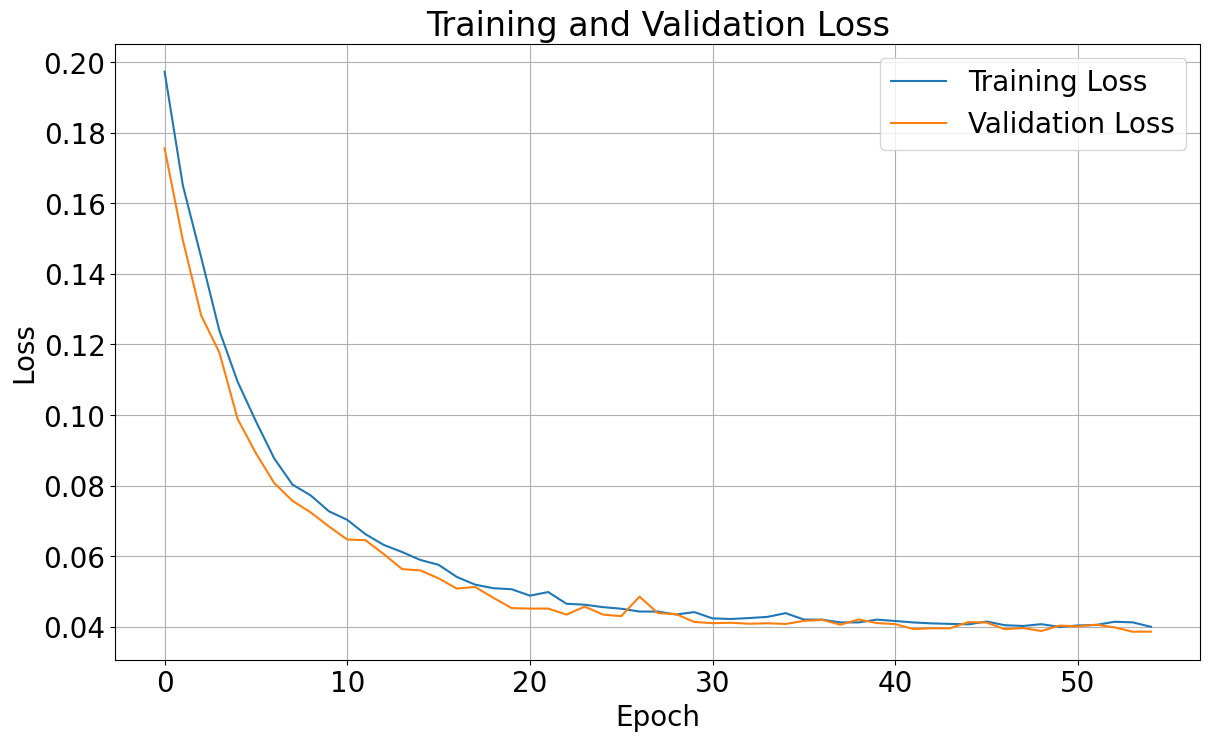

469/469 [==============================] - 1s 2ms/step - loss: 0.0390
Loss on Validation: 0.03901124373078346


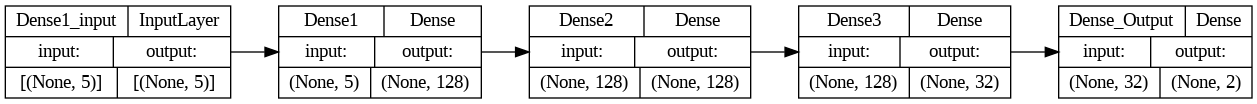

In [27]:
# @title TRAIN NEURAL NETWORK - INVERSE PROBLEM


def rearrange_training_data(training_data):
    inputs = np.array([[sample[0], sample[1], sample[4], sample[5], sample[6]] for sample in training_data])
    outputs = np.array([[sample[2], sample[3]] for sample in training_data])
    return inputs, outputs

X_inverse_train, y_inverse_train = rearrange_training_data(training_data)

model_inverse = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='selu', kernel_initializer=GlorotUniform(seed=seed), use_bias=False, name='Dense1', input_shape=(5,)),
        tf.keras.layers.Dense(128, activation='tanh', kernel_initializer=GlorotUniform(seed=seed), use_bias=False, name='Dense2'),
        tf.keras.layers.Dense(32,  activation='tanh', kernel_initializer=GlorotUniform(seed=seed), use_bias=True,  name='Dense3'),
        tf.keras.layers.Dense(2,  use_bias=False, name='Dense_Output')
])

model_inverse.compile(optimizer='adam', loss='mse')

history = model_inverse.fit(X_inverse_train, y_inverse_train, epochs=55, batch_size=256, validation_split=0.05)

plot_loss(history)

loss = model_inverse.evaluate(X_inverse_train, y_inverse_train)
print("Loss on Validation:", loss)

model_inverse.save("FEM_inverse_model.h5")
plot_model(model_inverse, to_file='FEM_inverse_model_plot.png', show_shapes=True, show_layer_names=True, rankdir='LR')
Image('FEM_inverse_model_plot.png')



In [42]:
# @title TEST NEURAL NETWORK - INVERSE PROBLEM

norm_vect_inverse = np.array([2000.0, 0.5, 100, 100, 100])
example_input_inverse = np.array([[example_input[0][0], example_input[0][1], max_u_example, max_u_coords[0], max_u_coords[1]]]) / norm_vect_inverse
predicted_output = model_inverse.predict(example_input_inverse) * [load_range[1], load_range[1]]
print("Predicted Loads:", np.round(predicted_output[0], 4))
print("Ground Truth:   ", example_input[0][-2 :])


1/1 [==============================] - 0s 32ms/step
Predicted Loads: [-1.8206 -4.8257]
Ground Truth:    [-2. -5.]


The results obtained are very interesting; despite the limited amount of generated data, this approach could be useful as an initial guess for an iterative process, aiming to save time without sacrificing accuracy.